
# Unit 2 Notebook — Correlation & Granger Causality

*A practical walkthrough with simulations you can tweak.*  
**Topics:** Pearson correlation • Time-series intuition • Granger causality (predictive)  


In [7]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels for Granger causality
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

np.random.seed(42)
pd.options.display.precision = 4



## 1) Pearson Correlation — intuition first

**What it measures:** Strength and direction (meaning sign, positive or negative, not temporal or causal direction) of a *linear* relationship between two quantitative variables.  
**Range:** -1 (perfect negative) to +1 (perfect positive); 0 means *no linear* relationship.

We'll simulate two scenarios:
1. **Linear relationship**: clear positive correlation.
2. **Curvy relationship**: strong association but *Pearson misses it* (hint: it's not linear).

### Pearson loves straight lines. Curves? Not so much.


Pearson r (linear case): 0.952


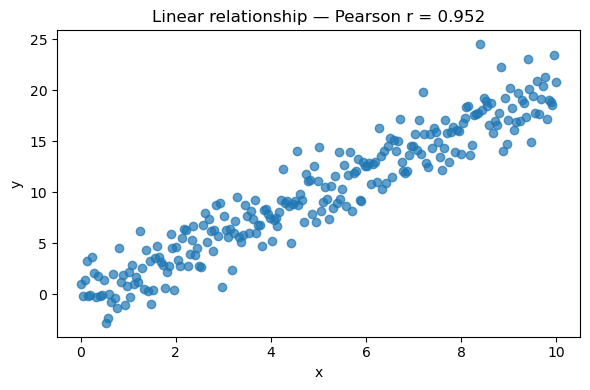

In [8]:
# --- Scenario 1: Linear relationship ---
n = 250
x = np.linspace(0, 10, n)
y = 2.0 * x + np.random.normal(0, 2, size=n)

r_linear = np.corrcoef(x, y)[0,1]
print(f"Pearson r (linear case): {r_linear:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7)
plt.title(f"Linear relationship — Pearson r = {r_linear:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


Pearson r (nonlinear case): -0.027  <-- low, despite obvious association


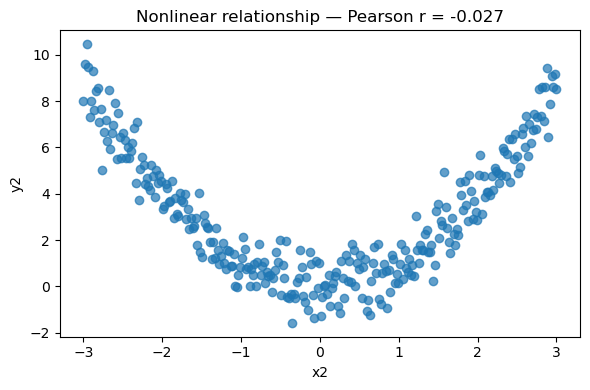

In [9]:
# --- Scenario 2: Nonlinear relationship (Pearson underestimates) ---
n = 300
x2 = np.linspace(-3, 3, n)
y2 = x2**2 + np.random.normal(0, 0.8, size=n)

r_nonlinear = np.corrcoef(x2, y2)[0,1]
print(f"Pearson r (nonlinear case): {r_nonlinear:.3f}  <-- low, despite obvious association")

plt.figure(figsize=(6,4))
plt.scatter(x2, y2, alpha=0.7)
plt.title(f"Nonlinear relationship — Pearson r = {r_nonlinear:.3f}")
plt.xlabel("x2")
plt.ylabel("y2")
plt.tight_layout()
plt.show()

# Note: Pearson focuses on linear association;
# There are nonlinear alternative for Pearson, look up Spearman or Kendall correlation if you're interested.


## 2) From correlation to *temporal* predictiveness

Correlation is **atemporal**: it ignores *order*.  
Time series let us ask a new question:

> **Does the past of X help predict the future of Y (beyond Y's own past)?**

That's the idea behind **Granger causality**.



### 2.1 Simulating a simple causal story (X → Y)

We'll create a system where **X drives Y with a lag**:
- Xₜ = 0.7·Xₜ₋₁ + noise
- Yₜ = 0.6·Yₜ₋₁ + **0.8·Xₜ₋₁** + noise

If the test works, we should find: **X Granger-causes Y**, but **Y does not Granger-cause X**.


In [10]:

def simulate_var1(n=400, burn=50, ax=0.7, ay=0.6, b_xy=0.8, b_yx=0.0, sx=1.0, sy=1.0):
    X = np.zeros(n + burn)
    Y = np.zeros(n + burn)
    for t in range(1, n + burn):
        X[t] = ax * X[t-1] + np.random.normal(scale=sx)
        Y[t] = ay * Y[t-1] + b_xy * X[t-1] + np.random.normal(scale=sy)
    return X[burn:], Y[burn:]

X, Y = simulate_var1()
df = pd.DataFrame({"X": X, "Y": Y})
df.head()


,X,Y
0,-2.6644,-3.8310
1,-0.0161,-3.3035
2,-0.2802,-3.1015
3,2.3773,-2.0258
4,1.6780,0.6622


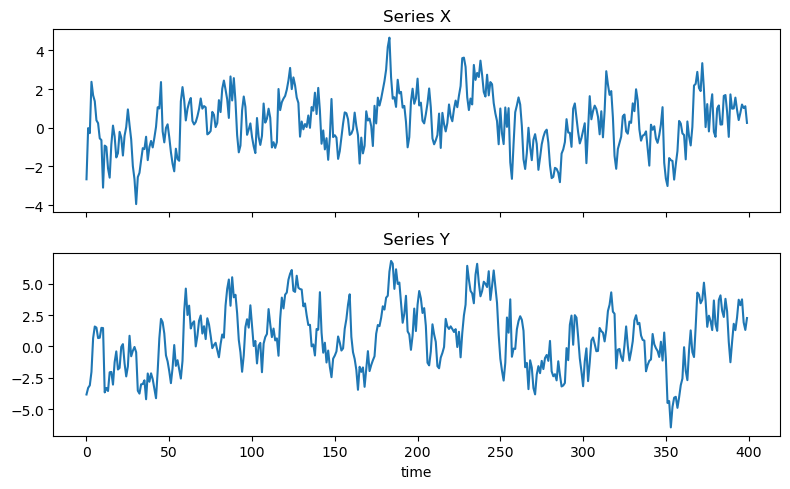

In [11]:
# Quick look at what the series look like
fig, axes = plt.subplots(2, 1, figsize=(8,5), sharex=True)
axes[0].plot(df["X"])
axes[0].set_title("Series X")
axes[1].plot(df["Y"])
axes[1].set_title("Series Y")
axes[1].set_xlabel("time")
plt.tight_layout()
plt.show()


In [12]:
# Granger test: Does X (lags) help predict Y?
# The function expects a 2D array with [Y, X] columns in this order.
maxlag = 3
print("H0: 'X does NOT Granger-cause Y'")
res_xy = grangercausalitytests(df[["Y","X"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_xy[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# If the p values are small (e.g., < 0.05), we reject H0 and conclude that X Granger-causes Y.

H0: 'X does NOT Granger-cause Y'
lag 1: p = 0.0000
lag 2: p = 0.0000
lag 3: p = 0.0000


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [13]:

# Reverse direction: Does Y Granger-cause X? (should NOT, in our simulation)
print("H0: 'Y does NOT Granger-cause X'")
res_yx = grangercausalitytests(df[["X","Y"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_yx[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# If the p values are small (e.g., < 0.05), we reject H0 and conclude that Y Granger-causes X.

H0: 'Y does NOT Granger-cause X'
lag 1: p = 0.0817
lag 2: p = 0.0241
lag 3: p = 0.0235


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



### 2.2 Caveats you must remember

- **Predictive ≠ causal mechanism.** Granger tests predictiveness in time, not true cause.  
- **Omitted common causes** can fool the test.  
- **Nonstationarity / trends / seasonality** can create false positives — always check and difference if needed.  
- **Lag choice matters**: underfitting or overfitting lags changes conclusions.  



## 3) Mini Exercise — Build, test, explain

1. **Simulate your own pair of time series** where **Y depends on X with a lag of 2**.  
   - Hint: make `Y[t] = 0.5*Y[t-1] + 0.9*X[t-2] + noise`.
2. **Run Granger tests** for lags 1..4 in **both directions**.  
3. **Explain** in 2–4 sentences why the *reverse* direction should (ideally) not be significant.
4. **(Bonus)** Add a seasonal driver to both and observe how it changes results; then remove it by differencing.

> Deliverable: a short markdown cell with your explanation + the printed p-values.


Granger causality tests: X → Y (does X help predict Y?)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=176.2048, p=0.0000  , df_denom=296, df_num=1
ssr based chi2 test:   chi2=177.9906, p=0.0000  , df=1
likelihood ratio test: chi2=139.6489, p=0.0000  , df=1
parameter F test:         F=176.2048, p=0.0000  , df_denom=296, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=170.4100, p=0.0000  , df_denom=293, df_num=2
ssr based chi2 test:   chi2=346.6359, p=0.0000  , df=2
likelihood ratio test: chi2=229.9345, p=0.0000  , df=2
parameter F test:         F=170.4100, p=0.0000  , df_denom=293, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=112.2968, p=0.0000  , df_denom=290, df_num=3
ssr based chi2 test:   chi2=345.0223, p=0.0000  , df=3
likelihood ratio test: chi2=228.9546, p=0.0000  , df=3
parameter F test:         F=112.2968, p=0.0000  , df_denom=290, df_num=3

Granger Causality
number of lags (no

C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


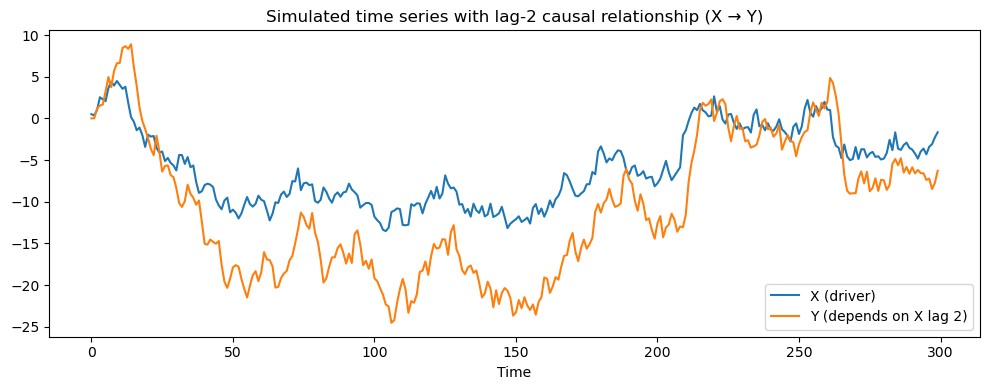


BONUS: Granger test with seasonal driver (can create false correlation)

Lag 1 p-value (with season): 0.0000
Lag 2 p-value (with season): 0.0000
Lag 3 p-value (with season): 0.0000
Lag 4 p-value (with season): 0.0000

After differencing (seasonality removed):

Lag 1 p-value (differenced): 0.2294
Lag 2 p-value (differenced): 0.0000
Lag 3 p-value (differenced): 0.0000
Lag 4 p-value (differenced): 0.0000


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [14]:
# Your answer goes here.

# Mini Exercise 3 — Build, test, explain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

np.random.seed(42)

# --- 1. Simulate data ---
n = 300
noise_x = np.random.normal(0, 1, n)
noise_y = np.random.normal(0, 1, n)

# independent driver X
X = np.cumsum(noise_x)   # random walk-like driver

# dependent variable Y (depends on X with lag=2)
Y = np.zeros(n)
for t in range(2, n):
    Y[t] = 0.5 * Y[t-1] + 0.9 * X[t-2] + noise_y[t]

# create DataFrame
data = pd.DataFrame({'X': X, 'Y': Y})

# --- 2. Granger causality tests ---
print("Granger causality tests: X → Y (does X help predict Y?)\n")
granger_xy = grangercausalitytests(data[['Y','X']], maxlag=4, verbose=True)

print("\nGranger causality tests: Y → X (reverse direction)\n")
granger_yx = grangercausalitytests(data[['X','Y']], maxlag=4, verbose=True)

# --- 3. Plot for visualization ---
plt.figure(figsize=(10,4))
plt.plot(data['X'], label="X (driver)")
plt.plot(data['Y'], label="Y (depends on X lag 2)")
plt.title("Simulated time series with lag-2 causal relationship (X → Y)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. BONUS: add a seasonal driver and observe effect ---
season = 2 * np.sin(np.linspace(0, 6*np.pi, n))
data['X_season'] = X + season
data['Y_season'] = Y + season

print("\nBONUS: Granger test with seasonal driver (can create false correlation)\n")
granger_season = grangercausalitytests(data[['Y_season','X_season']], maxlag=4, verbose=False)
for lag in range(1,5):
    pval = granger_season[lag][0]['ssr_ftest'][1]
    print(f"Lag {lag} p-value (with season): {pval:.4f}")

# Remove seasonality by differencing
diffed = data[['X_season','Y_season']].diff().dropna()
print("\nAfter differencing (seasonality removed):\n")
granger_diff = grangercausalitytests(diffed[['Y_season','X_season']], maxlag=4, verbose=False)
for lag in range(1,5):
    pval = granger_diff[lag][0]['ssr_ftest'][1]
    print(f"Lag {lag} p-value (differenced): {pval:.4f}")


In [ ]:
##**Explanation:**

In this simulation, Y depends on X with a lag of 2, so the Granger causality test for *X → Y* should have
a significant p-value around lag 2 (indicating that past values of X help predict Y).
In contrast, the reverse test (*Y → X*) should not be significant because Y is generated *from* X,
not the other way around — X evolves independently.

When we add a shared seasonal pattern to both, both directions may appear significant
because they now share a common periodic signal (a confounder).  
After differencing to remove the seasonality, the spurious relationship disappears,
and only the true causal direction (X → Y) remains significant.



---

### Wrap-up

- **Pearson**: quick check for linear association.  
- **Granger**: tests whether the past of one series improves prediction of another.  
- **Beware** trends/seasonality and omitted variables might influence your numbers.
  
